<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/VU_logo.png/800px-VU_logo.png?20161029201021" width="350">

### Programming large-scale parallel systems

# Gaussian elimination

## Contents

In this notebook, we will learn

- How to parallelize Gaussian elimination
- How to fix static load imbalance

## Gaussian elimination


System of linear algebraic equations

$$
\left[
\begin{matrix}
1 & 3 & 1 \\
1 & 2 & -1 \\
3 & 11 & 5 \\
\end{matrix}
\right]
\left[
\begin{matrix}
x \\
y \\
z  \\
\end{matrix}
\right]
=
\left[
\begin{matrix}
9 \\
1 \\
35  \\
\end{matrix}
\right]
$$

Elimination steps


$$
\left[
\begin{matrix}
1 & 3 & 1 & 9 \\
1 & 2 & -1 & 1 \\
3 & 11 & 5 & 35 \\
\end{matrix}
\right]
\rightarrow
\left[
\begin{matrix}
1 & 3 & 1 & 9 \\
0 & -1 & -2 & -8 \\
0 & 2 & 2 & 8 \\
\end{matrix}
\right]
\rightarrow
\left[
\begin{matrix}
1 & 3 & 1 & 9 \\
0 & 1 & 2 & 8 \\
0 & 2 & 2 & 8 \\
\end{matrix}
\right]
\rightarrow
\left[
\begin{matrix}
1 & 3 & 1 & 9 \\
0 & 1 & 2 & 8 \\
0 & 0 & -2 & -8 \\
\end{matrix}
\right]
\rightarrow
\left[
\begin{matrix}
1 & 3 & 1 & 9 \\
0 & 1 & 2 & 8 \\
0 & 0 & 1 & 4 \\
\end{matrix}
\right]
$$



### Serial implementation


In [1]:
function gaussian_elimination!(B)
    n,m = size(B)
    @inbounds for k in 1:n
        for t in (k+1):m
            B[k,t] =  B[k,t]/B[k,k]
        end
        B[k,k] = 1
        for i in (k+1):n 
            for j in (k+1):m
                B[i,j] = B[i,j] - B[i,k]*B[k,j]
            end
            B[i,k] = 0
        end
    end
    B
end

gaussian_elimination! (generic function with 1 method)

In [2]:
A = Float64[1 3 1; 1 2 -1; 3 11 5]
b = Float64[9,1,35]
B = [A b]
gaussian_elimination!(B)

3×4 Matrix{Float64}:
 1.0  3.0  1.0  9.0
 0.0  1.0  2.0  8.0
 0.0  0.0  1.0  4.0

## Parallelization


### Where can we extract parallelism?

```julia
n,m = size(B)
for k in 1:n
    for t in (k+1):m
        B[k,t] =  B[k,t]/B[k,k]
    end
    B[k,k] = 1
    for i in (k+1):n 
        for j in (k+1):m
            B[i,j] = B[i,j] - B[i,k]*B[k,j]
        end
        B[i,k] = 0
    end
end
```

### Two possible data partitions

<div>
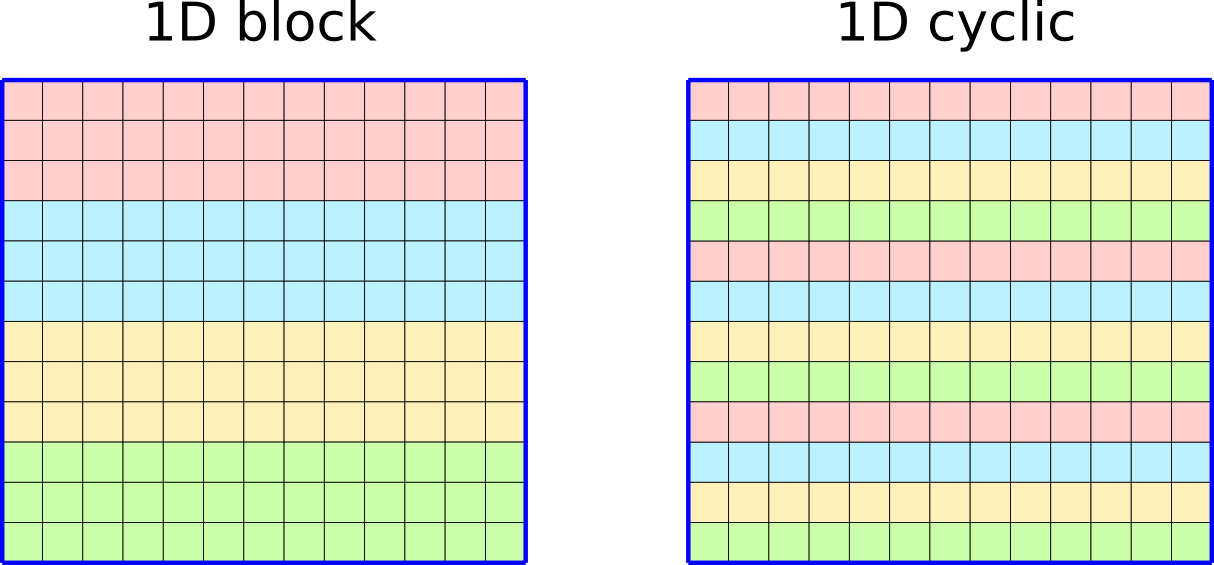
</div>

### Which is the work per process at iteration k ?



<div>
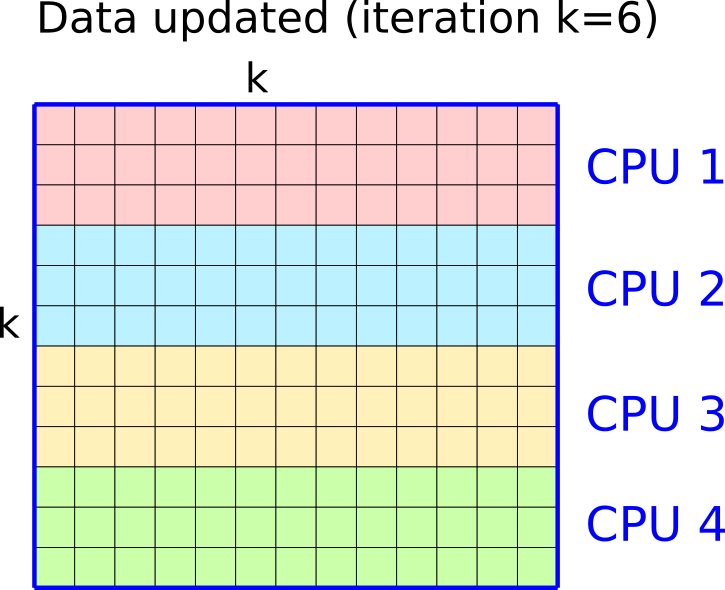
</div>

<div>
    <br>
    <br>
    <br>
    <br>
</div>

<div>
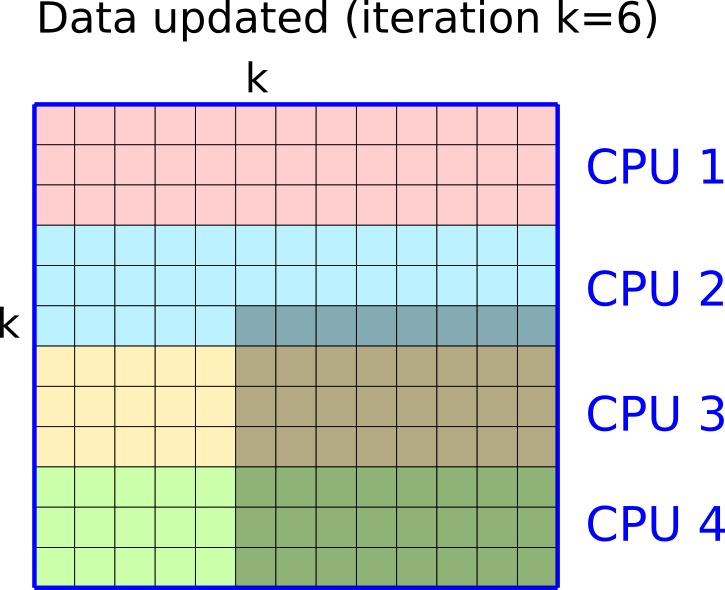
</div>

### Load imbalance

- CPUs with rows <k are idle during iteration k
- Bad load balance means bad speedups, as some CPUs are waiting instead of doing useful work
- Solution: cyclic partition             

### Cyclic partition

- Less load imbalance
- Same data dependencies as 1d block partition
- Useful for some problems with predictable load imbalance
- A form of static load balancing
- Not suitable for all communication patterns (e.g. Jacobi)

<div>
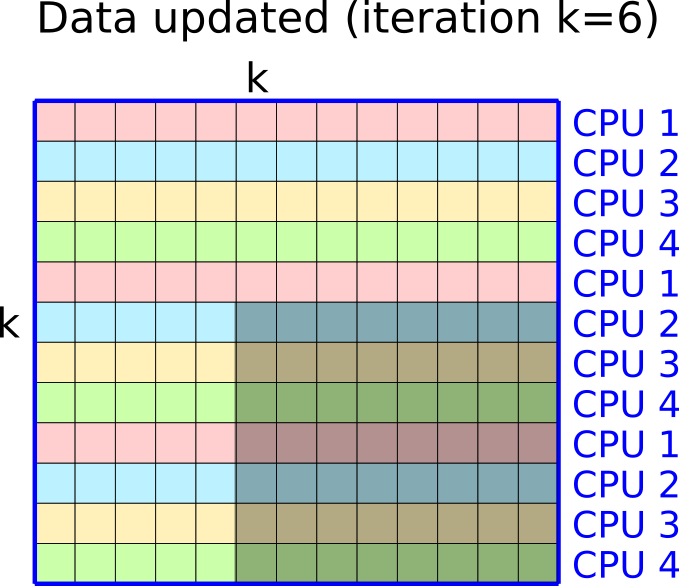
</div>

## Exercise

- The actual parallel implementation is let as an exercise
- Implement both 1d block and 1d cyclic partitions and compare performance
- Closely related with Floyd's algorithm
- Generate input matrix with function below (a random matrix is not enough, we need a non singular matrix that does not require pivoting)

In [ ]:
function tridiagonal_matrix(n)
    C = zeros(n,n)
    stencil = [(-1,2,-1),(-1,0,1)]
    for i in 1:n
        for  (coeff,o) in zip((-1,2,-1),(-1,0,1))
            j = i+o
            if j in 1:n
                C[i,j] = coeff
            end
        end
    end
    C
end

In [ ]:
n = 5
C = tridiagonal_matrix(n)
b = ones(n)
gaussian_elimination!(C)